In [4]:
import pandas as pd
from pathlib import Path
from PIL import Image
root = Path("/media/t9s9/SSD_ubuntu/datasets/VGGSound/")

In [7]:
df = pd.read_csv(root / 'vggsound.csv')
df.info()
df.head()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 199176 entries, 0 to 199175
Data columns (total 5 columns):
 #   Column      Non-Null Count   Dtype 
---  ------      --------------   ----- 
 0   youtube_id  199176 non-null  object
 1   time_start  199176 non-null  int64 
 2   caption     199176 non-null  object
 3   split       199176 non-null  object
 4   time_end    199176 non-null  int64 
dtypes: int64(2), object(3)
memory usage: 7.6+ MB


,youtube_id,time_start,caption,split,time_end
0,---g-f_I2yQ,1,people marching,test,11
1,--0PQM4-hqg,30,waterfall burbling,train,40
2,--56QUhyDQM,185,playing tennis,train,195
3,--5OkAjCI7g,40,people belly laughing,train,50
4,--8puiAGLhs,30,car engine starting,train,40


In [ ]:
df['filename'] = df.apply(
    lambda row: str(Path(row['split']) / f"{row['youtube_id']}_{row['time_start']:06d}_{row['time_end']:06d}.mp4"),
    axis=1)
df = df.drop(columns=['time_start', 'time_end', 'youtube_id'])
df = df.rename({'caption': 'target'}, axis=1)
df.target = df.target.astype('category')
df.split = df.split.astype('category')
# df = df[df.filename.apply(lambda x: (root / x).exists())]

df.info()
df.head()

In [ ]:
for split, group in df.groupby('split', as_index=False):
    print(f"Split {split}: {group.shape[0]} datapoints.")
    # assert group.shape[0] == len(list((root / split).iterdir()))
    # group = group.drop(columns='split')
    # group.to_parquet(root / f'annot_{split}.parquet', index=False)

In [ ]:
train_df = pd.read_parquet(root / 'annot_train.parquet')
test_df =  pd.read_parquet(root / 'annot_test.parquet')
train_df.filename = train_df.filename.apply(lambda x: Path(x).stem)
test_df.filename = test_df.filename.apply(lambda x: Path(x).stem)
meta = pd.read_csv('/media/ts/SSD_ubuntu/datasets/VGGSound/extracted_metadata.csv')

In [ ]:
train_df.shape # 164433 13625

In [ ]:
corrupted_train = set(train_df.filename).difference(set(meta.filename))
corrupted_train = list(map(lambda x: str('train' / Path(x).with_suffix('.mp4')), corrupted_train))
corrupted_test = set(test_df.filename).difference(set(meta.filename))
corrupted_test = list(map(lambda x: str('test' / Path(x).with_suffix('.mp4')), corrupted_test))
corrupted = corrupted_train + corrupted_test
corrupted

In [21]:
train_df.shape # 164433 13625

(164486, 2)

In [19]:
corrupted_train = set(train_df.filename).difference(set(meta.filename))
corrupted_train = list(map(lambda x: str('train' / Path(x).with_suffix('.mp4')), corrupted_train))
corrupted_test = set(test_df.filename).difference(set(meta.filename))
corrupted_test = list(map(lambda x: str('test' / Path(x).with_suffix('.mp4')), corrupted_test))
corrupted = corrupted_train + corrupted_test
corrupted

['train/_jgbCOhFOvk_000175_000185.mp4',
 'train/6EBHSXGYe8I_000012_000022.mp4',
 'train/2cBdAvV0_zs_000080_000090.mp4',
 'train/QE0UcPR1Yck_000203_000213.mp4',
 'train/COmq6eCydDg_000181_000191.mp4',
 'train/bIrEG2jDNuE_000355_000365.mp4',
 'train/yMg0ELEz0bc_000000_000010.mp4',
 'train/OIqUka8BOS8_011654_011664.mp4',
 'train/SJws8LT72OA_000550_000560.mp4',
 'train/JsTj-8bNObw_000694_000704.mp4',
 'train/NucyWgxj364_000005_000015.mp4',
 'train/9wtuDVCro8Y_000212_000222.mp4',
 'train/qWIzaRz4nxM_000090_000100.mp4',
 'train/muI78m0GDgk_000520_000530.mp4',
 'train/qT-PiebI034_000057_000067.mp4',
 'train/9ZOSht8cnH0_000226_000236.mp4',
 'train/YoXPXWrYe9c_000271_000281.mp4',
 'train/e6Rxo-_4r7s_000119_000129.mp4',
 'train/n1EKnZf-Iqw_000711_000721.mp4',
 'train/bCRmVhJLg20_000367_000377.mp4',
 'train/WrO6kv9Az_Y_000057_000067.mp4',
 'train/bxbcS2zVffk_000547_000557.mp4',
 'train/N609loYkFJo_018453_018463.mp4',
 'train/H-atPOp07tA_000163_000173.mp4',
 'train/CzOOJMpFVrs_000041_000051.mp4',


In [6]:
_split = 'test'

auditory_cap = pd.read_csv(root / "captions/auditory_captions.csv")
auditory_cap[['split', 'filename']] = auditory_cap.apply(lambda x: x.filename.split('/'), axis=1, result_type='expand')
auditory_cap_split = auditory_cap[auditory_cap['split'] == _split].copy()
auditory_cap_split['filename'] = auditory_cap_split['filename'].apply(lambda s: Path(s).stem)
auditory_cap_split = auditory_cap_split.set_index('filename').drop(columns='split').rename(columns={'caption': 'auditory_caption'})

In [7]:
visual_cap = pd.read_parquet(root / f"captions/visual_captions_{_split}_full.parquet")
visual_cap_test = visual_cap.set_index('filename')
def func(row):
    if row['cc_sim'] > row['coco_sim']:
        return row['caption_cc']
    return row['caption_coco']

visual_cap_test['captions'] = visual_cap_test.apply(func, axis=1)
visual_cap_test = visual_cap_test.drop(columns=['cc_sim', 'coco_sim', 'caption_cc', 'caption_coco'])
visual_cap_test.to_parquet(root / f"captions/visual_captions_{_split}.parquet")

In [90]:
test_df = pd.read_parquet(root / f"annot_{_split}.parquet")
test_df.filename = test_df.filename.apply(lambda s: Path(s).stem)
test_df = test_df.set_index('filename')

In [92]:
join_df = test_df.join(visual_cap_test, how='inner', validate='1:1').join(auditory_cap_split, how='inner', validate='1:1').join(image_id, how='inner', validate='1:1')

In [93]:
join_df.to_parquet(root / f'extraction-10s/full_annot_{_split}.parquet')

In [3]:
pd.read_parquet('/media/ts/SSD_ubuntu/datasets/VGGSound/captions/visual_captions_train.parquet')

,filename,caption_cc,caption_coco,cc_sim,coco_sim
0,--0PQM4-hqg_000030_000040,a man and a woman were reportedly attacked by ...,A river filled with lots of water next to a fo...,22.764668,23.542835
1,--56QUhyDQM_000185_000195,the video shows a young woman playing tennis o...,A person on a court with a tennis racket.,27.624752,24.959127
2,--5OkAjCI7g_000040_000050,"person, left, and person share a laugh as they...",Two young boys brushing their teeth in front o...,15.750554,20.034439
3,--8puiAGLhs_000030_000040,how to change the speed of your car.,a close up of a car driving on a road ...,27.435398,21.584728
4,--96EN9NUQM_000242_000252,mechanic measuring the time on the meter.,A hand holding a small clock on a table.,19.865294,21.414248
...,...,...,...,...,...
164426,zzsUhaDSqzI_000115_000125,the machine was used to cut down trees and shr...,A factory machine that is making a machine.,17.674637,24.029299
164427,zzsUhaDSqzI_000145_000155,"in this video, person can be seen working on a...",A man working on a machine in a factory ...,29.650635,25.072639
164428,zztvx3WUBss_000030_000040,the video shows a young boy jumping over a wall.,a person jumping a skate board in the air \n ...,29.447617,21.921173
164429,zzvSVusPPgM_000030_000040,biological species in the jungle.,A couple of animals that are standing in the g...,23.711067,18.956148


Auditory Caption: Heavy rain is falling and splashing on a surface.
Visual Caption  : A person holding an umbrella in the rain.


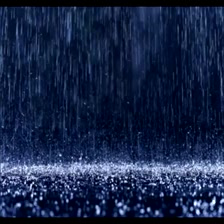

In [85]:
dp = join_df.iloc[2458]
print("Auditory Caption:", dp.auditory_caption)
print("Visual Caption  :", dp.visual_caption)
Image.open(root / "extraction-10s/images/test" / (dp.name + f'_i{dp.position[len(dp.position) // 2]:03}.jpg'))